# Implementation of an LSTM with no HPO

Just to verify the environment works and get the RD done.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: Tesla V100S-PCIE-32GB


### Read in data

In [15]:
# Read in data
years = ["2020", "2021", "2022", "2023", "2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("./data/2019_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"./data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
daily_avg = all_data.groupby(all_data["ISO Time"].dt.date).mean().drop(columns=["ISO Time"])
daily_avg

Data Collected


,Temperature (C),Humidity (%),Pressure (kPa),Air Quality (Ohms)
ISO Time,,,,
2019-01-01,3.921022,99.820841,97.024068,37537.675939
2019-01-02,0.105646,99.987139,97.121288,61590.439583
2019-01-03,-1.659410,99.961500,97.648393,46746.797917
2019-01-04,-0.907194,100.000000,97.522331,47088.403472
2019-01-05,0.174472,100.000000,96.894481,48220.809722
...,...,...,...,...
2024-12-27,4.556431,92.038789,102.783070,740815.044618
2024-12-28,1.841710,89.554899,102.251135,972417.461760
2024-12-29,0.557732,92.770739,101.906279,945363.057791


### Basic Visualization

We'll just look at temp for now.

<Figure size 1400x500 with 0 Axes>

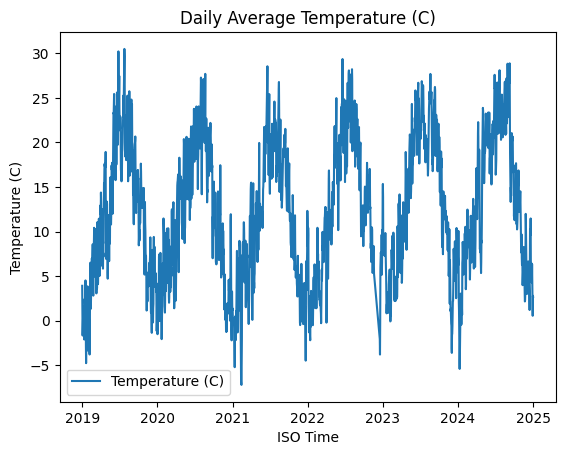

<Figure size 1400x500 with 0 Axes>

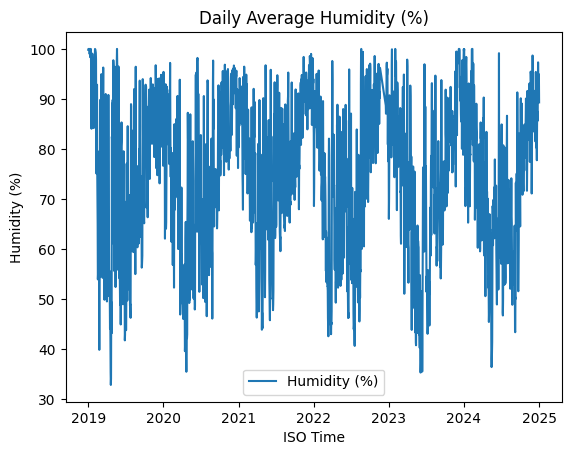

<Figure size 1400x500 with 0 Axes>

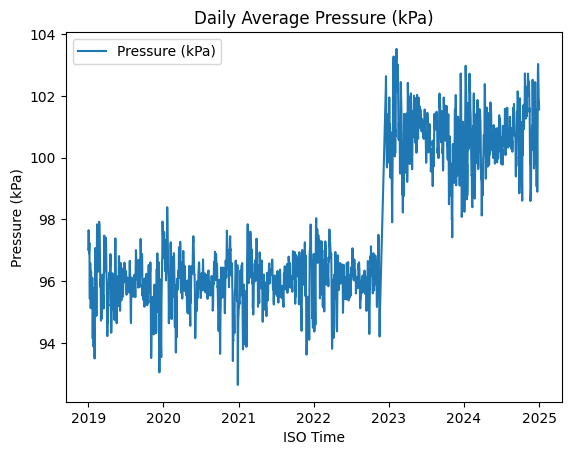

<Figure size 1400x500 with 0 Axes>

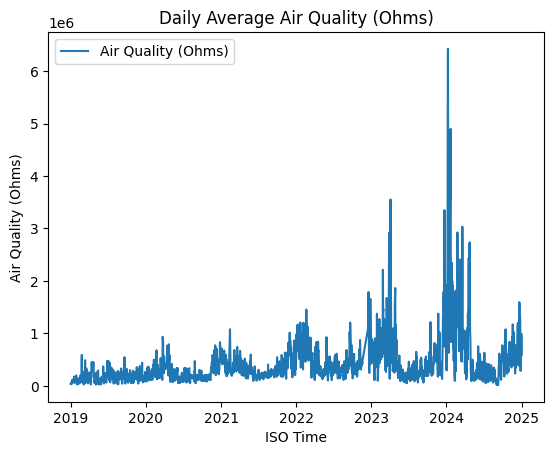

In [19]:
var_names = columns[1:]

for variable in var_names:
    plt.figure(figsize=(14, 5))
    daily_avg.plot(y=variable)
    plt.title(f"Daily Average {variable}")
    plt.ylabel(variable)
    plt.show()



### Model definition and training

In [23]:
data = daily_avg["Temperature (C)"]
data

ISO Time
2019-01-01    3.921022
2019-01-02    0.105646
2019-01-03   -1.659410
2019-01-04   -0.907194
2019-01-05    0.174472
                ...   
2024-12-27    4.556431
2024-12-28    1.841710
2024-12-29    0.557732
2024-12-30    2.800865
2024-12-31    2.686530
Name: Temperature (C), Length: 2165, dtype: float64

In [30]:
# Scale Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.to_numpy().reshape(-1,1))

# Hyper Parameters
look_back = 10
n_splits = 5
epochs = 50
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Prepare dataset
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled, look_back)
X = X[:, :, np.newaxis]  # (samples, time_steps, features)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out
    

cuda


Train

In [31]:
tscv = TimeSeriesSplit(n_splits=n_splits)
rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = LSTMModel().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        with tqdm(train_loader, unit="batch", desc=f"Fold {fold+1} Epoch {epoch+1}") as tepoch:
            for xb, yb in tepoch:
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t).cpu().numpy()
        y_test_inv = scaler.inverse_transform(y_test_t.cpu().numpy())
        y_pred_inv = scaler.inverse_transform(y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
        print(f"Fold {fold+1} RMSE: {rmse:.4f}")
        rmse_scores.append(rmse)
    
print(f"\nAverage RMSE across folds: {np.mean(rmse_scores):.4f}")

Fold 1


Fold 1 Epoch 50: 100%|██████████| 12/12 [00:00<00:00, 464.99batch/s, loss=0.00417]


Fold 1 RMSE: 3.2384
Fold 2


Fold 2 Epoch 50: 100%|██████████| 23/23 [00:00<00:00, 462.67batch/s, loss=0.00622]


Fold 2 RMSE: 2.7324
Fold 3


Fold 3 Epoch 50: 100%|██████████| 34/34 [00:00<00:00, 462.30batch/s, loss=0.00496]


Fold 3 RMSE: 2.3455
Fold 4


Fold 4 Epoch 50: 100%|██████████| 45/45 [00:00<00:00, 453.31batch/s, loss=0.00514]


Fold 4 RMSE: 1.8850
Fold 5


Fold 5 Epoch 50: 100%|██████████| 57/57 [00:00<00:00, 455.35batch/s, loss=0.00373]


Fold 5 RMSE: 1.9277

Average RMSE across folds: 2.4258
